### Importing Imp Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True

### Loading data

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data_pytorch/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Some imp functions

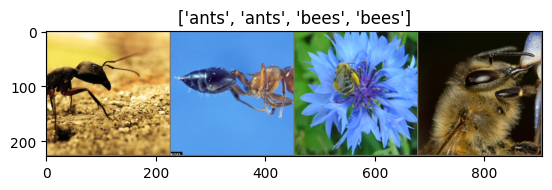

In [12]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [14]:
def visualize_model(model, num_images=12):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])
        
        model.train(mode=was_training)

In [16]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

## WideResNet

Convolutional neural networks (CNNs) have achieved state-of-the-art performance on a wide range of image recognition tasks, revolutionizing the field of computer vision. Nevertheless, CNNs can have limited performance due to their depth and are computationally costly. In order to overcome these drawbacks, Sergey Zagoruyko and Nikos Komodakis' paper "Wide residual networks" presents a novel CNN architecture called wide residual networks (WRNs), which achieves competitive accuracy with deeper CNNs while being more effective at training and better at generalizing to new data.<br><br>
The following major architectural innovations form the foundation of WRNs:<br>
  <strong>Large Width</strong>: WRNs are able to extract a broader range of features from images because their convolutional layers  contain a large number of channels.<br>
  <strong>Residual Connections</strong>: In order to improve information flow and avoid vanishing gradients, WRNs include residual connections, which link layers to their skip connections directly.<br>
  <strong>Bottleneck Design</strong>: To reduce computational complexity and increase efficiency, WRNs use a bottleneck design, in which the number of channels is decreased in the middle of each convolutional block.<br>
  <strong>Weight Standardization</strong>: WRNs normalize the weights of their convolutional layers by applying weight standardization, which enhances generalization performance.<br>
  <strong>Batch Normalization</strong>: To improve training stability and performance, WRNs use batch normalization to normalize the activations of their convolutional layers.<br><br><br>
WRNs integrate a number of cutting-edge technological innovations, such as:<br>
  <strong>Effective Training Methods</strong>: To increase training speed and generalization, the authors of the paper created effective training methods for WRNs, such as early stopping<br>
  <strong>Data Augmentation</strong>: To improve robustness to changes in image appearance, WRNs use data augmentation techniques like random cropping and horizontal flipping to artificially increase the size of the training dataset.<br>
  <strong>Weight Initialization</strong>: To improve training stability and performance, WRNs employ He initialization for their convolutional layers. This initializes weights from a normal distribution with a specified variance.<br><br><br>  
WRNs have shown outstanding results on a number of image recognition benchmarks, including:<br>
  <strong>ImageNet Classification</strong>: On the ImageNet classification dataset, WRNs outperformed deeper CNNs in terms of accuracy, reaching state-of-the-art levels.<br>
  <strong>COCO Object Detection</strong>: WRNs demonstrated their efficacy in object detection tasks by outperforming ResNet-101 on the COCO object detection benchmark.<br>
  <strong>CIFAR-10 Classification</strong>: WRNs further validated their performance capabilities by achieving state-of-the-art accuracy on the CIFAR-10 classification dataset.<br><br><br>
These findings demonstrate the competitive performance and wide-ranging application potential of WRNs, establishing them as a potent and effective CNN architecture for image recognition tasks.<br>

### Model initialise

In [17]:
model_1 = models.wide_resnet50_2(weights='IMAGENET1K_V1')
num_ftrs = model_1.fc.in_features

model_1.fc = nn.Linear(num_ftrs, 2)

model_ft = model_1.to(device)

criterion = nn.CrossEntropyLoss()


optimizer_1 = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_1, step_size=7, gamma=0.1)

### Model Training

In [18]:
model_1 = train_model(model_1, criterion, optimizer_1, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6613 Acc: 0.5861
val Loss: 0.1749 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4015 Acc: 0.8156
val Loss: 0.1940 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4777 Acc: 0.8074
val Loss: 0.2270 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4889 Acc: 0.7951
val Loss: 0.2508 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.5255 Acc: 0.7705
val Loss: 0.2142 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.3818 Acc: 0.8238
val Loss: 0.2173 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.4954 Acc: 0.7705
val Loss: 0.5677 Acc: 0.7843

Epoch 7/24
----------
train Loss: 0.4849 Acc: 0.8033
val Loss: 0.2064 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3157 Acc: 0.8525
val Loss: 0.2149 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.2301 Acc: 0.8893
val Loss: 0.1951 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2687 Acc: 0.8689
val Loss: 0.1993 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3242 Acc: 0.8566
val Loss: 0.2019 Acc: 0.9412

Ep

### Observing modules in model

In [19]:
for modules in model_1.modules():
    print(modules)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

### Visualising model results

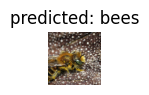

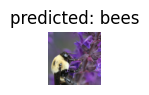

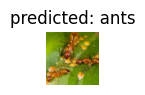

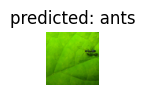

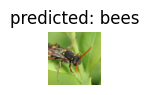

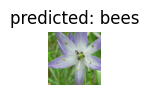

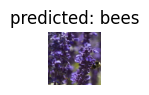

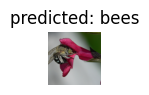

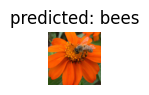

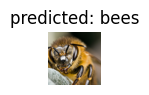

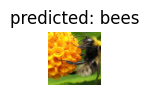

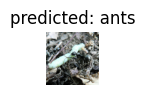

In [20]:
visualize_model(model_1)

In [21]:
#  torch.onnx.export(model_1, x.cuda(), 'model_1.onnx')

### LAYER BY LAYER STATE

In [22]:
model_1_nodes = get_graph_node_names(model_1)
model_1_nodes

C:\Users\divya\anaconda3\envs\pytorch_prep\Lib\site-packages\torch\overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
C:\Users\divya\anaconda3\envs\pytorch_prep\Lib\site-packages\torch\overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
C:\Users\divya\anaconda3\envs\pytorch_prep\Lib\site-packages\torch\overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
C:\Users\divya\anaconda3\envs\pytorch_prep\Lib\site-packages\torch\overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


(['x',
  'conv1',
  'bn1',
  'relu',
  'maxpool',
  'layer1.0.conv1',
  'layer1.0.bn1',
  'layer1.0.relu',
  'layer1.0.conv2',
  'layer1.0.bn2',
  'layer1.0.relu_1',
  'layer1.0.conv3',
  'layer1.0.bn3',
  'layer1.0.downsample.0',
  'layer1.0.downsample.1',
  'layer1.0.add',
  'layer1.0.relu_2',
  'layer1.1.conv1',
  'layer1.1.bn1',
  'layer1.1.relu',
  'layer1.1.conv2',
  'layer1.1.bn2',
  'layer1.1.relu_1',
  'layer1.1.conv3',
  'layer1.1.bn3',
  'layer1.1.add',
  'layer1.1.relu_2',
  'layer1.2.conv1',
  'layer1.2.bn1',
  'layer1.2.relu',
  'layer1.2.conv2',
  'layer1.2.bn2',
  'layer1.2.relu_1',
  'layer1.2.conv3',
  'layer1.2.bn3',
  'layer1.2.add',
  'layer1.2.relu_2',
  'layer2.0.conv1',
  'layer2.0.bn1',
  'layer2.0.relu',
  'layer2.0.conv2',
  'layer2.0.bn2',
  'layer2.0.relu_1',
  'layer2.0.conv3',
  'layer2.0.bn3',
  'layer2.0.downsample.0',
  'layer2.0.downsample.1',
  'layer2.0.add',
  'layer2.0.relu_2',
  'layer2.1.conv1',
  'layer2.1.bn1',
  'layer2.1.relu',
  'layer2.1.c

In [23]:
return_nodes = {
    'x' : 'input',
    'conv1' : 'conv',
    'layer1.2.relu_2': 'layer1',
    'layer2.3.relu_2': 'layer2',
    'layer3.5.relu_2': 'layer3',
    'layer4.2.relu_2': 'layer4',
    'avgpool' : 'pool'
}

In [24]:
model_1_rep = create_feature_extractor(model_1, return_nodes=return_nodes)
intermediate_outputs = model_1_rep(inputs[0].unsqueeze(0).cuda())

input torch.Size([224, 224])


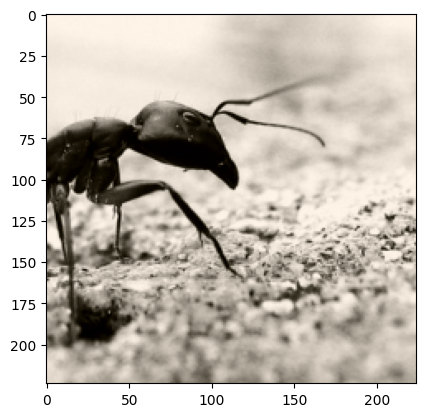

conv torch.Size([112, 112])


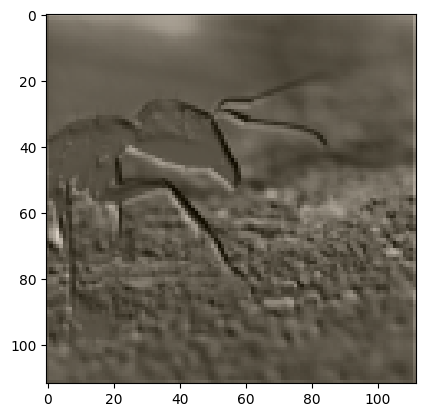

layer1 torch.Size([56, 56])


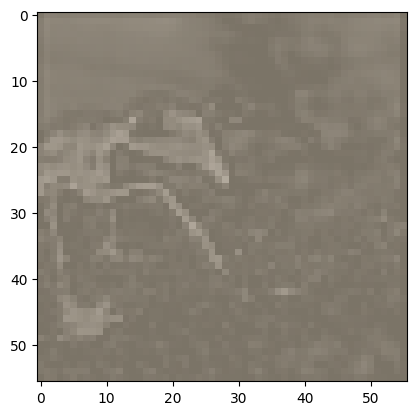

layer2 torch.Size([28, 28])


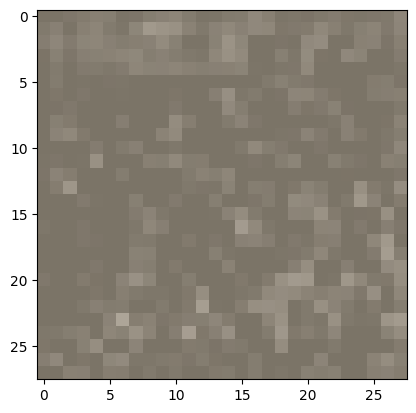

layer3 torch.Size([14, 14])


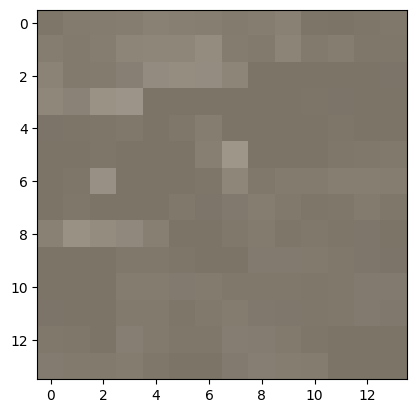

layer4 torch.Size([7, 7])


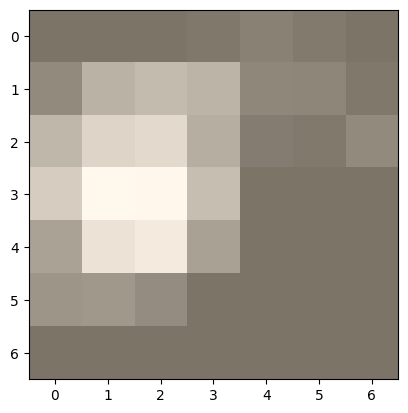

pool torch.Size([1, 1])


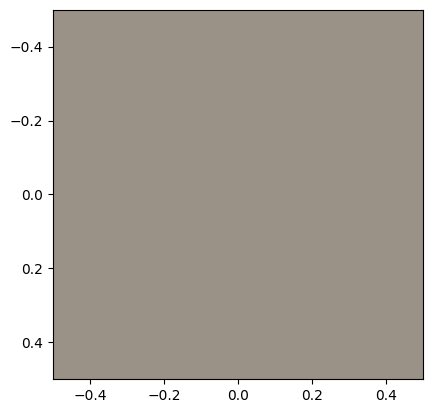

In [25]:
for key, values in intermediate_outputs.items():
    print(key, values[0][0].size())
    imshow(values[0][0].unsqueeze(0).cpu().detach())

## ConvNeXt

In recent years, convolutional neural networks (CNNs) have become the de facto architecture for tasks involving object detection and image classification. However, the dominance of CNNs has been called into question by the introduction of Transformers, a more modern and potent architecture. In response to this challenge, Zhuang Liu et al.'s paper "A ConvNet for the 2020s" presents ConvNeXts, a new ConvNet architecture that retains the efficiency and simplicity of conventional ConvNets while demonstrating competitive performance with Transformers.<br><br>
ConvNeXts are simple to implement and train because they are built entirely from standard ConvNet modules. ConvNeXts' principal architectural innovations include:<br>
  <strong>Depthwise Separable Convolution</strong>: Depthwise separable convolutions are more computationally complex and efficient than standard convolutions.<br>
  <strong>Hierarchical Architecture</strong>: ConvNeXts can more successfully capture long-range dependencies in images by implementing a hierarchical architecture that resembles the structure of Transformers.<br>
  <strong>Inverted Bottleneck Block</strong>: Performance and computational efficiency are increased with the introduction of an inverted bottleneck block design.<br><br><br>
ConvNeXts integrate a number of cutting-edge technological innovations:<br>
  <strong>Layer Normalization</strong>: Layer normalization is a more flexible and effective normalization technique that can be used in place of batch normalization.<br>
  <strong>Gaussian Error Linear Units (GELU) Activation</strong>: Using GELU as the activation function provides a more efficient and smoother non-linearity than rectified linear units (ReLU).<br>
  <strong>Effective Training Methods</strong>: Creating effective training methods, such as Cutmix and Mixup, to enhance robustness and generalization.<br><br><br>
ConvNeXts have proven to perform remarkably well on a range of benchmarks:<br>
  <strong>ImageNet Classification</strong>: Outperforming several Transformer-based architectures with an accuracy of 87.8% top-1.<br>
  <strong>COCO Object Detection</strong>: Outperforming Swin Transformers on the COCO object detection benchmark is COCO Object Detection.<br>
  <strong>ADE20K Semantic Segmentation</strong>:Securing cutting-edge results on the ADE20K semantic segmentation dataset is the goal of ADE20K semantic segmentation.<br><br><br>
These outcomes demonstrate ConvNeXts' efficacy across a range of computer vision tasks and position them as a competitive and exciting architecture going forward.

### Model Initialisation

In [26]:
model_2 = models.convnext_tiny(weights='IMAGENET1K_V1')

model_2.fc = nn.Linear(num_ftrs, 2)

model_2 = model_2.to(device)

criterion = nn.CrossEntropyLoss()


optimizer_2 = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_2, step_size=7, gamma=0.1)

### Printing Model Modules

In [27]:
for modules in model_2.modules():
    print(modules)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

### Model Training

In [28]:
model_2 = train_model(model_2, criterion, optimizer_2,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3845 Acc: 0.5123
val Loss: 0.8085 Acc: 0.4575

Epoch 1/24
----------
train Loss: 0.8820 Acc: 0.4877
val Loss: 0.7452 Acc: 0.4575

Epoch 2/24
----------
train Loss: 0.7573 Acc: 0.5123
val Loss: 0.7666 Acc: 0.4575

Epoch 3/24
----------
train Loss: 0.7476 Acc: 0.5697
val Loss: 0.7191 Acc: 0.4575

Epoch 4/24
----------
train Loss: 0.7374 Acc: 0.5328
val Loss: 0.8880 Acc: 0.4575

Epoch 5/24
----------
train Loss: 0.7223 Acc: 0.5082
val Loss: 0.7077 Acc: 0.4641

Epoch 6/24
----------
train Loss: 0.7538 Acc: 0.5205
val Loss: 0.7508 Acc: 0.5425

Epoch 7/24
----------
train Loss: 0.7113 Acc: 0.5369
val Loss: 0.6893 Acc: 0.5359

Epoch 8/24
----------
train Loss: 0.6910 Acc: 0.5328
val Loss: 0.7056 Acc: 0.5294

Epoch 9/24
----------
train Loss: 0.6821 Acc: 0.5656
val Loss: 0.6882 Acc: 0.5490

Epoch 10/24
----------
train Loss: 0.6815 Acc: 0.5738
val Loss: 0.6990 Acc: 0.5359

Epoch 11/24
----------
train Loss: 0.6985 Acc: 0.5451
val Loss: 0.6998 Acc: 0.5229

Ep

### Visualising Model Results

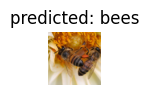

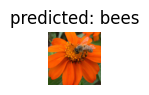

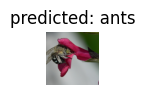

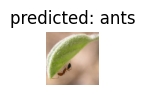

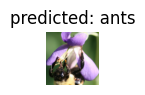

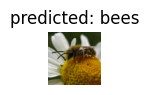

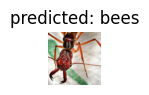

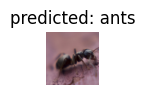

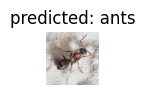

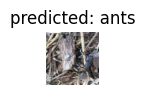

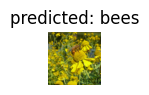

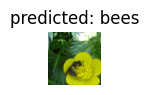

In [29]:
visualize_model(model_2)

In [30]:
#  torch.onnx.export(model_2, x.cuda(), 'model_2.onnx')

### LAYER BY LAYER STATE

In [31]:
model_2_nodes = get_graph_node_names(model_2)
model_2_nodes

(['x',
  'features.0',
  'features.1.0.features_1_0_layer_scale',
  'features.1.0.block.0',
  'features.1.0.block.1',
  'features.1.0.block.2',
  'features.1.0.block.3',
  'features.1.0.block.4',
  'features.1.0.block.5',
  'features.1.0.block.6',
  'features.1.0.mul',
  'features.1.0.stochastic_depth',
  'features.1.0.add',
  'features.1.1.features_1_1_layer_scale',
  'features.1.1.block.0',
  'features.1.1.block.1',
  'features.1.1.block.2',
  'features.1.1.block.3',
  'features.1.1.block.4',
  'features.1.1.block.5',
  'features.1.1.block.6',
  'features.1.1.mul',
  'features.1.1.stochastic_depth',
  'features.1.1.add',
  'features.1.2.features_1_2_layer_scale',
  'features.1.2.block.0',
  'features.1.2.block.1',
  'features.1.2.block.2',
  'features.1.2.block.3',
  'features.1.2.block.4',
  'features.1.2.block.5',
  'features.1.2.block.6',
  'features.1.2.mul',
  'features.1.2.stochastic_depth',
  'features.1.2.add',
  'features.2.0.permute',
  'features.2.0.features_2_0_weight',
 

In [32]:
return_nodes = {
    'x' : 'input',
    'features.1.2.add': 'layer1',
    'features.2.1': 'layer2',
    'features.3.2.add': 'layer3',
    'features.4.1': 'layer4',
    'features.5.8.add': 'layer5',
    'features.6.1': 'layer6',
    'features.7.2.add': 'layer7',
    'avgpool' : 'pool'
}

In [33]:
model_2_rep = create_feature_extractor(model_2, return_nodes=return_nodes)
intermediate_outputs = model_2_rep(inputs[0].unsqueeze(0).cuda())

input torch.Size([224, 224])


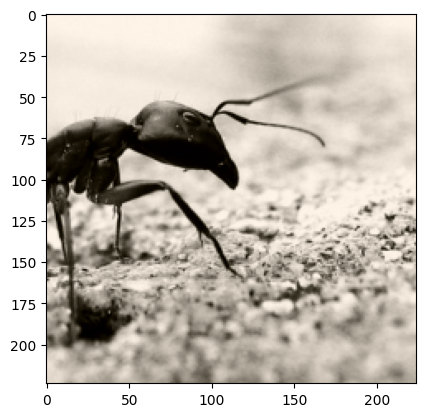

layer1 torch.Size([56, 56])


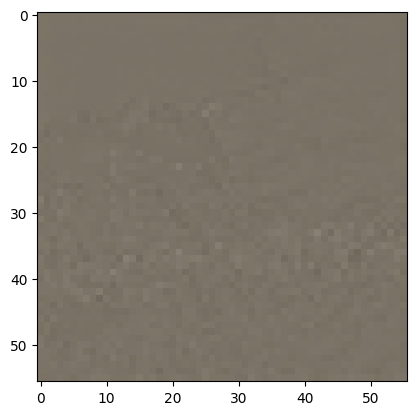

layer2 torch.Size([28, 28])


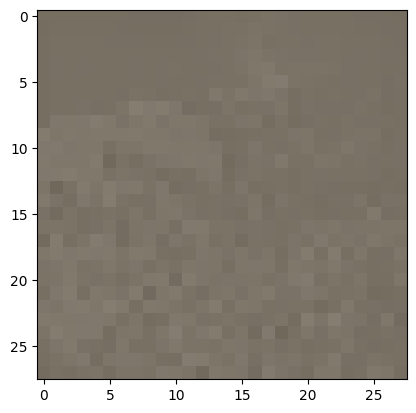

layer3 torch.Size([28, 28])


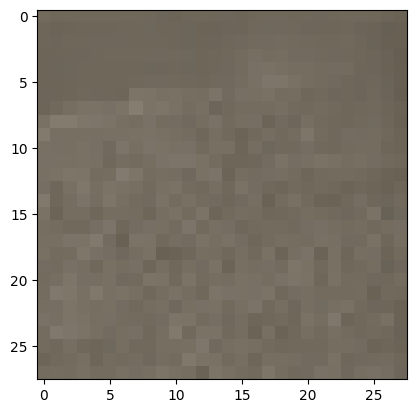

layer4 torch.Size([14, 14])


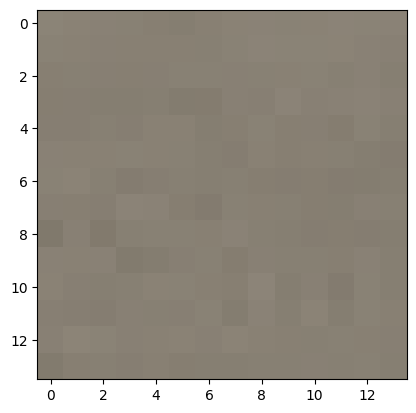

layer5 torch.Size([14, 14])


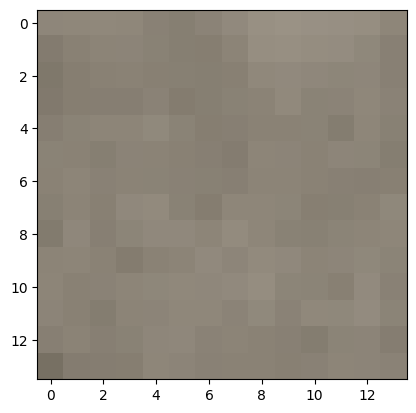

layer6 torch.Size([7, 7])


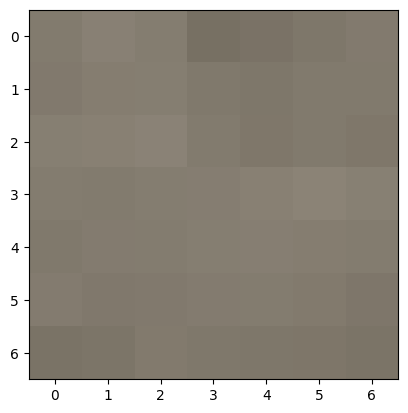

layer7 torch.Size([7, 7])


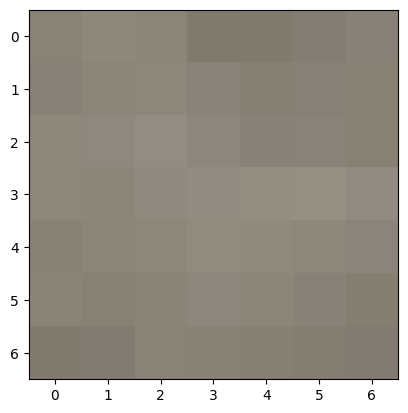

pool torch.Size([1, 1])


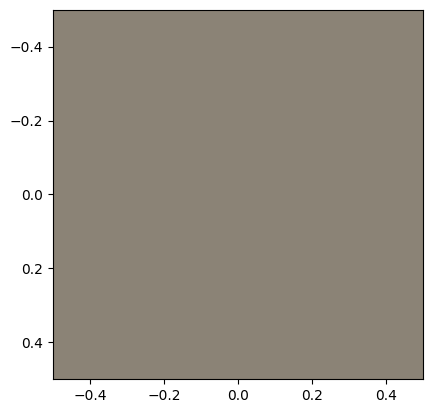

In [34]:
for key, values in intermediate_outputs.items():
    print(key, values[0][0].size())
    imshow(values[0][0].unsqueeze(0).cpu().detach())

In [42]:
model_2_rep = create_feature_extractor(model_2, return_nodes=return_nodes)
intermediate_outputs = model_2_rep(inputs[3].unsqueeze(0).cuda())

input torch.Size([224, 224])


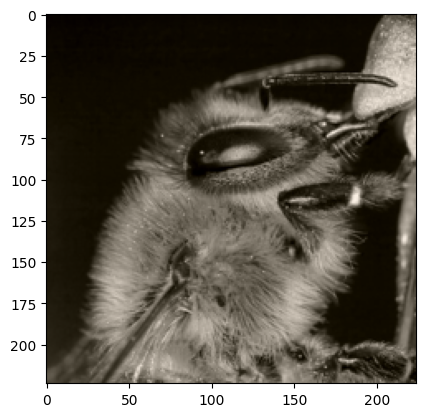

layer1 torch.Size([56, 56])


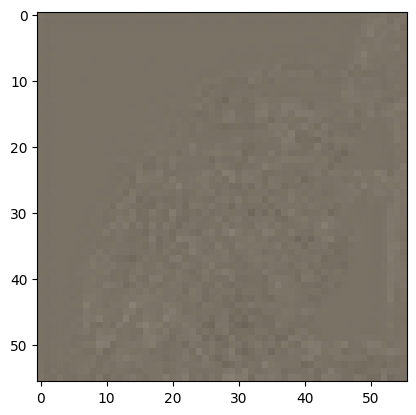

layer2 torch.Size([28, 28])


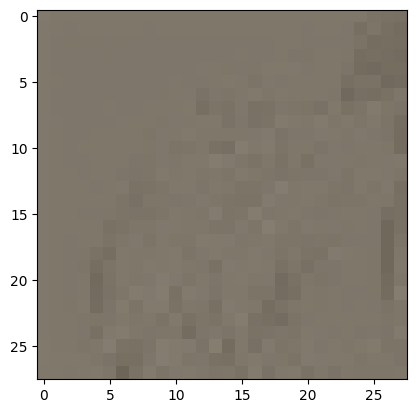

layer3 torch.Size([28, 28])


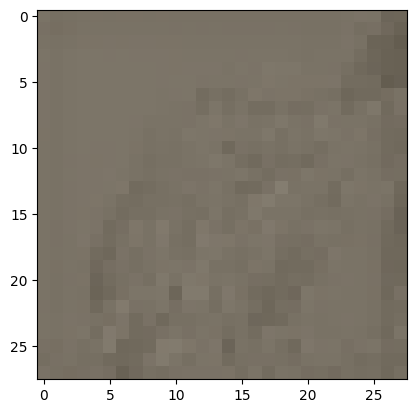

layer4 torch.Size([14, 14])


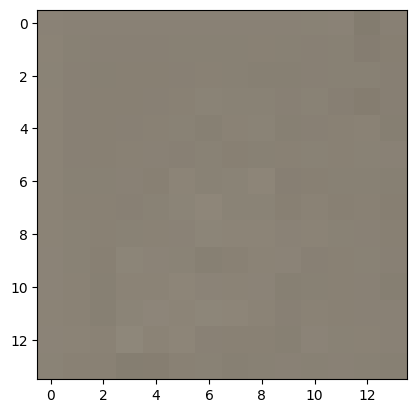

layer5 torch.Size([14, 14])


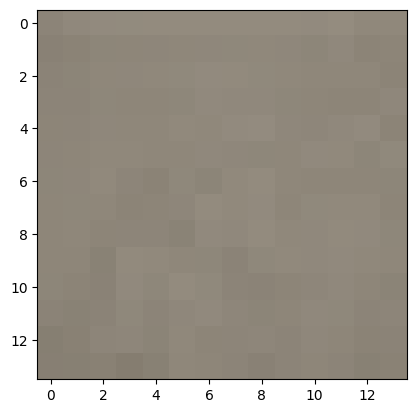

layer6 torch.Size([7, 7])


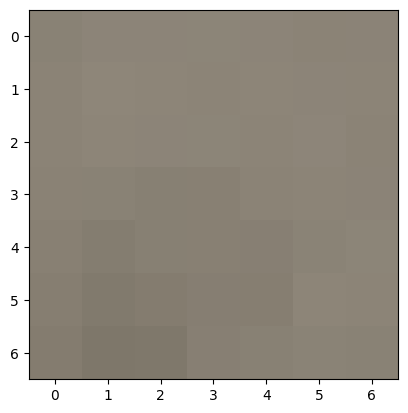

layer7 torch.Size([7, 7])


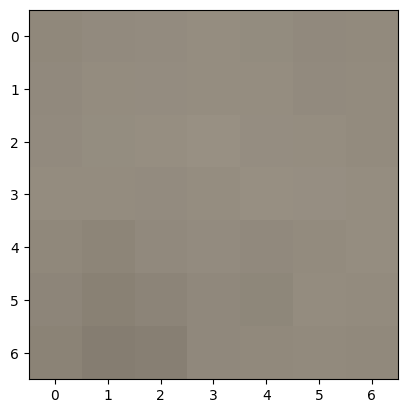

pool torch.Size([1, 1])


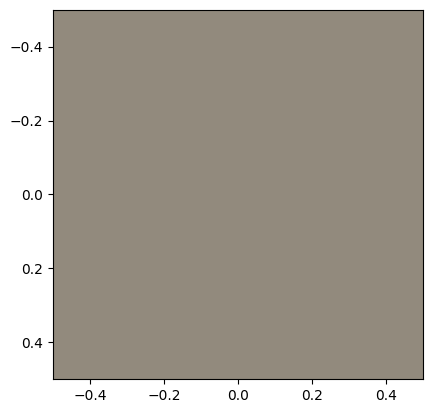

In [43]:
for key, values in intermediate_outputs.items():
    print(key, values[0][0].size())
    imshow(values[0][0].unsqueeze(0).cpu().detach())

### Comparisoin of models on Inference on custom images

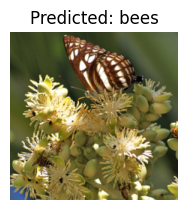

In [35]:
visualize_model_predictions(
    model_1,
    img_path='data_pytorch/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

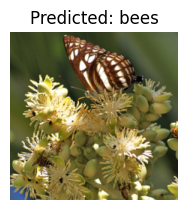

In [36]:
visualize_model_predictions(
    model_2,
    img_path='data_pytorch/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

### REFERENCES

1. <b>WideResNet</b> - Zagoruyko, S., & Komodakis, N. (2016). Wide Residual Networks. ArXiv. /abs/1605.07146
<br>
2. <b>ConvNeXt</b> - Liu, Z., Mao, H., Wu, C., Feichtenhofer, C., Darrell, T., & Xie, S. (2022). A ConvNet for the 2020s. ArXiv. /abs/2201.03545
        